# Applying GrandPrix

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from GrandPrix import GrandPrix
from utils import plot_XY
%matplotlib inline

## Data description

In [42]:
Y = pd.read_csv('data/Guo/GuoTrainingData.csv', index_col=[0])

In [43]:
N, D = Y.shape

## Model Construction

In [44]:
guo = GrandPrix(Y.values)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

In [45]:
latent_dims = 2
n_inducing_points = 40
X_var = 0.028
vParams = {'Xvar':X_var}

## Without informative prior

In [6]:
guo.build_model(vParams=vParams, latent_dims=latent_dims, n_inducing_points = n_inducing_points)

In [7]:
guo.fit_model()

In [8]:
X_np = guo.get_latent_dims(2)

## With informative prior

In [46]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))
ct = np.zeros(N)
for il, l in enumerate(Y.index):
    s = l.split(' ')
    ct[il] = int(s[0])
prior_mean = np.zeros((N, latent_dims))
prior_mean[:, 0] = MapTo01(ct) 

priors = {'Priormean':prior_mean, 'Priorvar':0.1}

In [47]:
guo.build_model(priors, vParams, latent_dims=latent_dims, n_inducing_points = n_inducing_points)

In [48]:
guo.fit_model()

In [49]:
X_wp = guo.get_latent_dims(2)

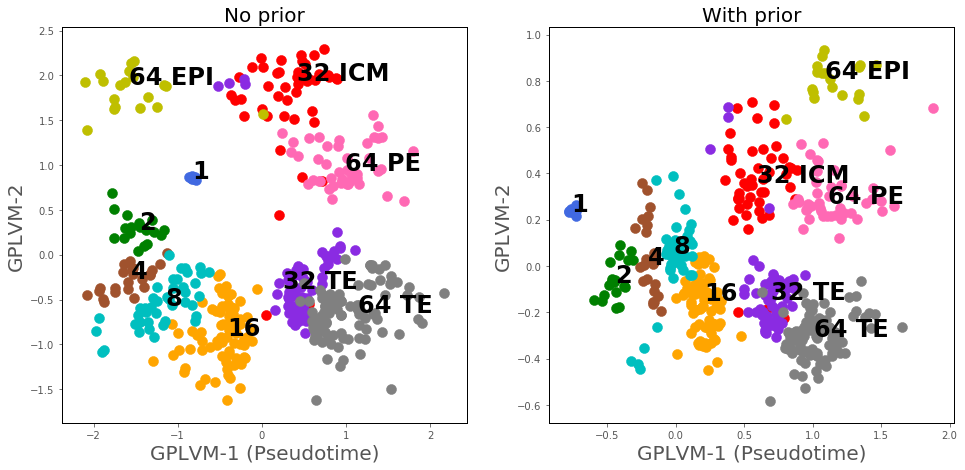

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(X_np[:,0], X_np[:,1], 'No prior', Y.index)
plt.subplot(2, 2, 2)
plot_XY(X_wp[:,0], X_wp[:,1], 'With prior', Y.index)

## 1-D optimization

In [17]:
x = prior_mean[:,0][:,None]
p = {'Priormean':x, 'Priorvar':0.1}
vParams = {'Xvar':X_var}
guo.build_model(p, vParams=vParams, latent_dims=1, n_inducing_points = 30)

In [18]:
guo.fit_model()

In [19]:
X_1d_opt = guo.get_latent_dims(1)

In [38]:
import sys

def plotcorrelation(X, Y, title, data_labels):
# def plotcorrelation():
    print("sumon")
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])

    label_order = ['1', '16', '2', '32 ICM', '32 TE', '4', '64 PE', '64 TE', '64 EPI', '8']
    yVals = np.array([1, 2, 4, 8, 16, 24, 32])
    yStrings = np.array(['1', '2', '4', '8', '16', '32', '64'])
#     print(X)
#     print(Y)
#     print(title)
#     print(data_labels)
#     print("sumon")
#     sys.exit()
    for l in label_order:
        x = Y[data_labels == l]
        if x[0]==64.:
            x = [x[i] - 32 for i in range(0,len(x))]
        elif x[0] == 1.:
            x = [x[i] - 0. for i in range(0, len(x))]
        elif x[0] == 4.:
            x = [x[i] + 0. for i in range(0, len(x))]
        elif x[0] == 32.:
            x = [x[i] - 8. for i in range(0, len(x))]
#         print(x)
        plt.scatter(X[data_labels == l], x, 100, label=l)
        plt.tick_params(labelsize=14)
        plt.yticks(yVals, yStrings)
        plt.xlabel('Pseudotime', fontsize = 20)
        plt.ylabel('Capture time', fontsize=20)
        plt.title(title, fontsize=20)
        plt.xlabel('Pseudotime', fontsize = 16)
        l = plt.legend(loc="lower right", fontsize=14, ncol=2, title="Capture stages", borderaxespad=0., columnspacing=0.2, handletextpad=0.1)
        plt.setp(l.get_title(), fontsize=16)

sumon
sumon


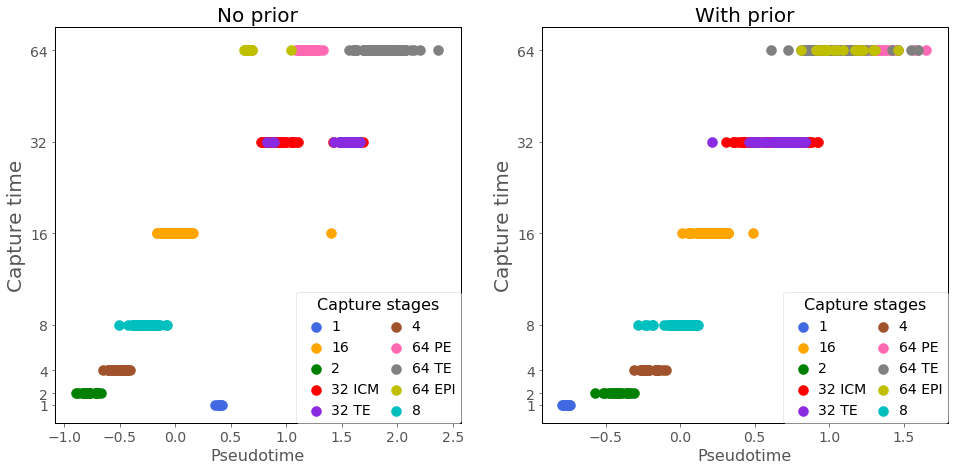

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plotcorrelation(X_1d_opt[:, 0], ct, 'No prior', Y.index)
plt.subplot(2, 2, 2)
plotcorrelation(X_wp[:, 0], ct, 'With prior', Y.index)